# Bayesian network model of predator-prey interactions

## 1. Description

Here, I build a Bayesian network implementation of the DAG where there is no feedback between the predator and the prey's behavior within a match.

Our objective is to use causal inference to model the predator-prey interaction as it changes throughout the predator's experience. Our DAG explains how we expect the system to work.

## 2. Prepare the session

I start by importing the libraries that I'll need to build the network.

In [1]:
# For the Bayesian network
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import CITests

# For data manipulations
from pathlib import Path
import pandas as pd
import numpy as np

# To import and export files
from joblib import dump
import os

I also define the path to the "outputs" folder of the project to save the trained model, the independence tests, and the testing data.

In [46]:
# Define the parent directory
parent_folder = os.path.abspath(
    os.path.join(os.getcwd(), os.pardir)
)

# Define the subfolder directory
output_folder = os.path.join(
    parent_folder, "outputs"
)

# Name of the outpout files
file_name1 = "BayesNet-model-data.joblib"
file_name2 = "BayesNet-fit.joblib"
file_name3 = "BayesNet-IndTests.joblib"

# Create the full path
output_path1 = os.path.join(
    output_folder, file_name1

)
output_path2 = os.path.join(
    output_folder, file_name2

)
output_path3 = os.path.join(
    output_folder, file_name3

)

## 3. Import the data

I import the data to build the network

In [28]:
# Parent folder
notebook_dir = Path.cwd()
parent_folder = notebook_dir.parent

# Data path
data_subfolder = "data"
file_name = "FraserFranco-etal-XXXX.csv"

# Full path to data file
file_path = parent_folder / data_subfolder / file_name

# Import dataset
data = pd.read_csv(file_path, index_col = None)

### 3.1 Visualize the data structure

Let's start by checking the data

In [29]:
data.head(n = 10)

,match_id,predator_id,xp_level,timestamp,game_mode,realm_id,environment_id,avatar_id,game_duration,prey_avg_rank,...,prior_prey_speed,prior_prey_heal,prior_success,prior_prey_captured,prior_chases_persec,prior_chase_count,range_prey_speed,iqrange_prey_speed,time_lag_matches,time_lag_session
0,DHCF1PHC,pred100494,novice,2021-01-02 14:47:16,Online,Yamaoka Estate,Family Residence,Wraith,399.848999,11.75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BHJFA1I0,pred100494,novice,2021-01-02 14:57:02,Online,The Macmillan Estate,Groaning Storehouse,Wraith,319.134979,11.75,...,2.129557,1.25,0.0,0.0,0.012505,5.0,0.149114,0.074557,9.766133,NaN
2,PMM9CDDR,pred100494,novice,2021-01-02 15:08:18,Online,Silent Hill,Midwich Elementary School,Doctor,687.513123,15.25,...,2.278671,0.00,0.0,0.0,0.025068,8.0,0.315710,0.157855,11.271783,NaN
3,3NT75SH7,pred100494,novice,2021-01-02 15:30:29,Online,Autohaven Wreckers,Blood Lodge,Huntress,528.620361,11.25,...,1.962961,1.75,0.0,0.0,0.027636,19.0,0.452196,0.224884,22.176050,NaN
4,MNL0ZWA5,pred100494,novice,2021-01-02 15:46:26,Online,Grave of Glenvale,Dead Dawg Saloon,Hillbilly,409.839844,14.50,...,2.415156,1.75,0.0,0.0,0.020809,11.0,0.819235,0.315710,15.946550,NaN
5,T0MHB9EN,pred100494,novice,2021-01-12 10:14:16,Online,Red Forest,Mother's Dwelling,Hag,398.106689,8.75,...,1.595922,0.00,0.0,0.0,0.009760,4.0,0.842429,0.376425,14067.845300,234.464088
6,ITTTMPEX,pred100494,novice,2021-01-18 02:38:28,Online,The Macmillan Estate,Ironworks of Misery,Wraith,354.199341,7.25,...,2.438350,0.00,0.0,0.0,0.015071,6.0,1.216089,0.380495,8184.188533,136.403142
7,VJDT9LDF,pred100494,novice,2021-01-18 02:57:38,Online,Autohaven Wreckers,Blood Lodge,Hag,744.018616,19.50,...,2.812010,0.25,0.0,0.0,0.022586,8.0,1.216089,0.333047,19.173067,136.403142
8,2TIUE2QD,pred100494,novice,2021-01-18 09:50:45,Online,Crotus Prenn Asylum,Father Campbell's Chapel,Wraith,535.973206,19.25,...,2.321259,2.75,1.0,1.0,0.022849,17.0,1.216089,0.285599,413.114583,136.403142
9,XP4PLOXG,pred100494,novice,2021-01-18 10:16:18,Online,Hawkins,Underground Complex,Hag,844.517029,17.75,...,2.151938,0.50,0.0,0.0,0.031718,17.0,1.216089,0.292485,25.544300,136.403142


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100062 entries, 0 to 100061
Data columns (total 39 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   match_id               100062 non-null  object 
 1   predator_id            100062 non-null  object 
 2   xp_level               100062 non-null  object 
 3   timestamp              100062 non-null  object 
 4   game_mode              100062 non-null  object 
 5   realm_id               100062 non-null  object 
 6   environment_id         100062 non-null  object 
 7   avatar_id              100062 non-null  object 
 8   game_duration          100062 non-null  float64
 9   prey_avg_rank          100062 non-null  float64
 10  total_xp_pred          100062 non-null  int64  
 11  cumul_xp_pred          100062 non-null  int64  
 12  hunting_success        100062 non-null  int64  
 13  points_predator        100062 non-null  int64  
 14  pred_speed             100062 non-nu

In [31]:
print("Colum names:", data.columns)

Colum names: Index(['match_id', 'predator_id', 'xp_level', 'timestamp', 'game_mode',
       'realm_id', 'environment_id', 'avatar_id', 'game_duration',
       'prey_avg_rank', 'total_xp_pred', 'cumul_xp_pred', 'hunting_success',
       'points_predator', 'pred_speed', 'prey_avg_speed',
       'predicted_mean_speed', 'predicted_sigma_speed', 'cluster',
       'hunting_type', 'chase_count', 'chase_count_success', 'attacks_count',
       'prey_avg_heal_count', 'prey_var_heal_count', 'prey_var_speed',
       'chase_success_ratio', 'chases_persec', 'prey_captured',
       'prior_prey_speed', 'prior_prey_heal', 'prior_success',
       'prior_prey_captured', 'prior_chases_persec', 'prior_chase_count',
       'range_prey_speed', 'iqrange_prey_speed', 'time_lag_matches',
       'time_lag_session'],
      dtype='object')


### 3.2 Delete anomalies in the data

Check the descriptive stats for chase count

In [32]:
# Get the DataFrame column
chase_count = data["chase_count"]

# Calculate quantiles
quantiles = chase_count.quantile([0.25, 0.5, 0.75])

# Get descriptive statistics
desc = chase_count.describe()

# Print results
print("Quantiles:")
print(quantiles)
print("\nDescriptive statistics:")
print(desc)

Quantiles:
0.25    14.0
0.50    19.0
0.75    24.0
Name: chase_count, dtype: float64

Descriptive statistics:
count    100062.000000
mean         19.781605
std           8.331573
min           0.000000
25%          14.000000
50%          19.000000
75%          24.000000
max         155.000000
Name: chase_count, dtype: float64


Some matches had a very high amounts of chases suggesting that players were farming for points. I remove these matches. I use an arbitrary threshold of 70 chases following the descriptive stats.

In [33]:
threshold = 70

# Filter instances above the threshold
anomalies = chase_count[chase_count > threshold]

# Count the number of instances above the threshold
obs_above_threshold = len(anomalies)

print("Number of observations above", threshold, ":", obs_above_threshold)

Number of observations above 70 : 60


I filter out any matches where the chase count was too high.

In [34]:
data = data[data["chase_count"] <= 70]
data = data[data["prior_chase_count"] <= 70]

## 4. Prepare data for the Bayesian network

### 4.1 Delete anomalies in the data

### 4.2 Check the distribution of the variables

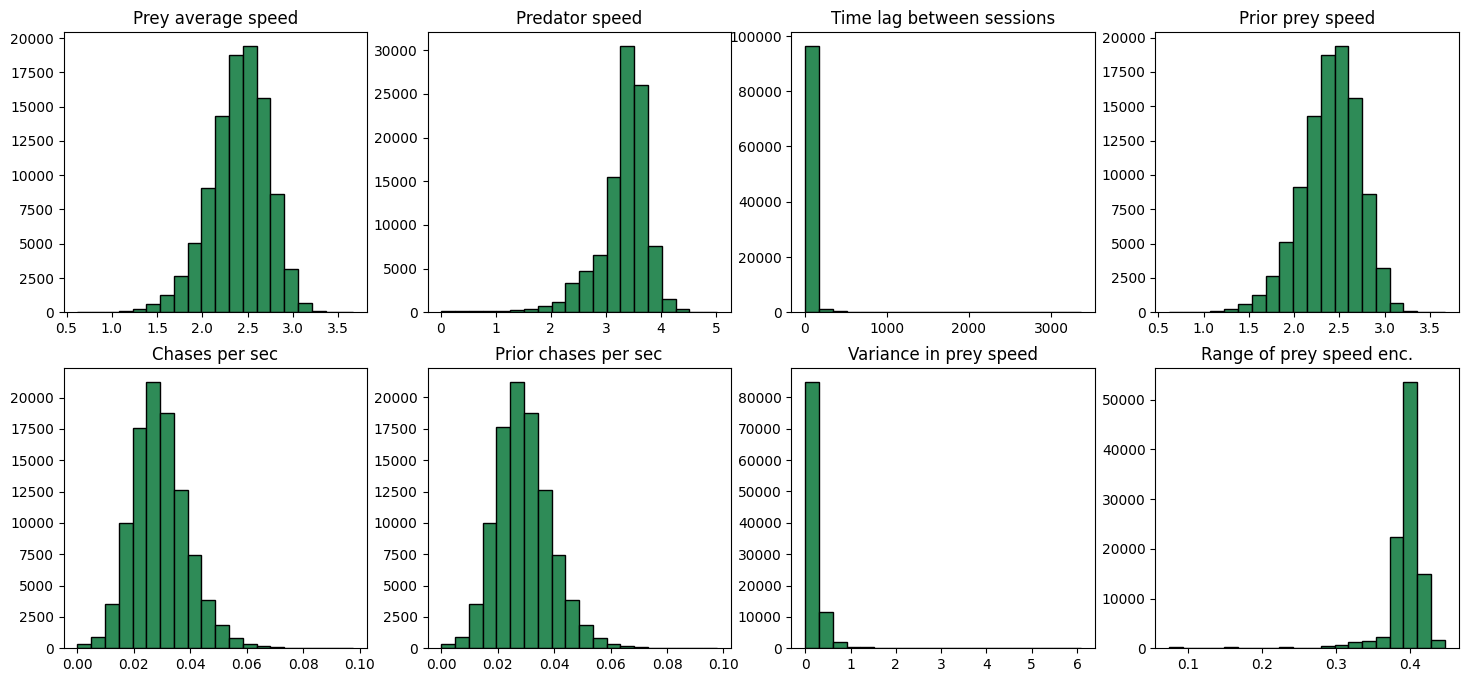

In [35]:
import matplotlib.pyplot as plt

# Define the columns and titles
columns = [
    "prey_avg_speed",
    "pred_speed",
    "time_lag_session",
    "prior_prey_speed",
    "chases_persec",
    "prior_chases_persec",
    "prey_var_speed",
    "iqrange_prey_speed"
]

titles = [
    "Prey average speed",
    "Predator speed",
    "Time lag between sessions",
    "Prior prey speed",
    "Chases per sec",
    "Prior chases per sec",
    "Variance in prey speed",
    "Range of prey speed enc."
]

# Create subplots
fig, axs = plt.subplots(
    nrows = 2, ncols = 4,
    figsize = (18, 8)
)

axs = axs.flatten()

# Plot histograms and set titles
for i, col in enumerate(columns):
    if i < len(titles):
        axs[i].hist(
            data[col],
            bins = 20,
            color = "seagreen",
            edgecolor = "black"
        )
        axs[i].set_title(titles[i])

# Adjust layout
plt.show()

### 4.3 Transform skewed variables

I will log transform the time lag between each session and the variance in speed of the prey group as both will be otherwise difficult to bin in their current form.

In [36]:
# Columns to log-transform
columns_to_log = [
    "time_lag_session",
    "prey_var_speed"    
]

# Log transform selected columns
for col in columns_to_log:
    new_col_name = col + "_log"
    data[new_col_name] = np.log(data[col])

Plot the results

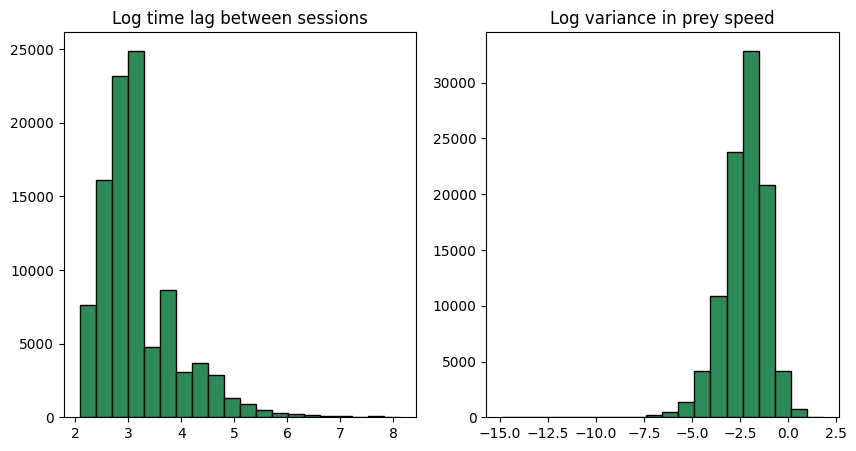

In [37]:
fig, axs = plt.subplots(
    nrows = 1, ncols = 2,
    figsize = (10, 5)
)
axs[0].hist(
    data["time_lag_session_log"], bins = 20,
    color = "seagreen",
    edgecolor = "black"
)
axs[1].hist(
    data["prey_var_speed_log"], bins = 20,
    color = "seagreen",
    edgecolor = "black"
)

axs[0].set_title("Log time lag between sessions")
axs[1].set_title("Log variance in prey speed")

plt.show()

### 4.4 Discretize variables

#### 4.4.1 Quantile-based

I start by discretizing the continuous variables that can be easily discretized with a quantile-based approach with 3 bins.

I do it for :
- **the average speed of the prey group**
- **the average speed of the prey group in the previous match**

In [38]:
# Function to create bins
def create_bins(data, column, num_bins = 3):
    labels = ["Slower", "Average", "Faster"]
    data[f"{column}_bin"] = pd.qcut(
        x = data[column],
        q = num_bins,
        labels = labels
    )

# Columns to bin
columns_to_bin = [
    "prey_avg_speed",
    "prior_prey_speed"
]

# Run the function
for column in columns_to_bin:
    create_bins(data, column)

# Print the results
columns = [
    "prey_avg_speed_bin",
    "prior_prey_speed_bin",
]

# Print value counts
for col in columns:
    print(data[col].value_counts())

Slower     33230
Faster     33230
Average    33229
Name: prey_avg_speed_bin, dtype: int64
Slower     33230
Faster     33230
Average    33229
Name: prior_prey_speed_bin, dtype: int64


Now, I discretize the following variables using 5 bins :

- **variance in speed of the prey group**
- **time lag between sessions**
- **inter-quantile range for prey speed**

In [39]:
# Function to create bins
def create_bins(data, column, num_bins = 5):
    labels = ["Q1", "Q2", "Q3", "Q4", "Q5"]
    data[f"{column}_bin"] = pd.qcut(
        x = data[column],
        q = num_bins,
        labels = labels
    )

# Columns to bin
columns_to_bin = [
    "prey_var_speed_log",
    "time_lag_session_log",
    "iqrange_prey_speed"
]

# Run the function
for column in columns_to_bin:
    create_bins(data, column)

# Print the results
columns = [
    "prey_var_speed_log_bin",
    "time_lag_session_log_bin",
    "iqrange_prey_speed_bin"
]

# Print value counts
for col in columns:
    print(data[col].value_counts())

Q1    19918
Q2    19918
Q4    19918
Q5    19918
Q3    19917
Name: prey_var_speed_log_bin, dtype: int64
Q2    19706
Q1    19699
Q3    19699
Q4    19697
Q5    19694
Name: time_lag_session_log_bin, dtype: int64
Q1    20022
Q4    19988
Q2    19979
Q3    19856
Q5    19845
Name: iqrange_prey_speed_bin, dtype: int64


#### 4.4.2 Quantile-based with custom criteria

I use a custom criteria using the values of the distribution to discretize :

- **Predator speed**

In [40]:
# Custom bins and labels
bins = [min(data["pred_speed"]), 3, 3.8, max(data["pred_speed"])]
labels = ["Slower", "Average", "Faster"]

# Create bins based on custom criteria
data["pred_speed_bin"] = pd.cut(
    data["pred_speed"],
    bins = bins,
    labels = labels
)

# Print value counts
print(data["pred_speed_bin"].value_counts())

Average    74531
Slower     17546
Faster      7612
Name: pred_speed_bin, dtype: int64


I use a similar approach for :

- **Chases per second**

In [41]:
# Custom bins and labels
bins = [
    min(data["chases_persec"]),
    0.025,
    0.04,
    max(data["chases_persec"])
]
labels = ["Low", "Average", "High"]

# Create bins based on custom criteria
data["chases_persec_bin"] = pd.cut(
    data["chases_persec"],
    bins = bins,
    labels = labels
)

# Print value counts
print(data["chases_persec_bin"].value_counts())

Average    51993
Low        34677
High       12870
Name: chases_persec_bin, dtype: int64


Same thing for :

- **Chases per second in the match before**

In [42]:
# Custom bins and labels
bins = [
    min(data["prior_chases_persec"]),
    0.025,
    0.04,
    max(data["prior_chases_persec"])
]
labels = ["Low", "Average", "High"]

# Create bins based on custom criteria
data["prior_chases_persec_bin"] = pd.cut(
    data["chases_persec"],
    bins = bins,
    labels = labels
)

# Print value counts
print(data["prior_chases_persec_bin"].value_counts())

Average    51993
Low        34677
High       12870
Name: prior_chases_persec_bin, dtype: int64


### 4.5 Select variables for the Bayesian network

I then prepare a filtered dataset that I use to fit the model. I extract only the variables that I will use to build the model structure.

In [43]:
# Select relevant variables
selected_variables = [
    "predator_id",
    "xp_level",
    "time_lag_session_log_bin",
    "pred_speed_bin",
    "prey_avg_speed_bin",
    "prey_var_speed_log_bin",
    "iqrange_prey_speed_bin",
    "chases_persec_bin",
    "prey_captured",
    "prior_chases_persec_bin",
    "prior_prey_captured",
    "prior_prey_speed_bin"
]

# Subset the data
model_data = data[selected_variables]

# Drop the first row for every player ID (NaN)
#subset = subset.dropna()

Check the model data

In [44]:
model_data.info()
model_data.head(n = 10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99690 entries, 1 to 100061
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   predator_id               99690 non-null  object  
 1   xp_level                  99690 non-null  object  
 2   time_lag_session_log_bin  98495 non-null  category
 3   pred_speed_bin            99689 non-null  category
 4   prey_avg_speed_bin        99689 non-null  category
 5   prey_var_speed_log_bin    99589 non-null  category
 6   iqrange_prey_speed_bin    99690 non-null  category
 7   chases_persec_bin         99540 non-null  category
 8   prey_captured             99690 non-null  int64   
 9   prior_chases_persec_bin   99540 non-null  category
 10  prior_prey_captured       99690 non-null  float64 
 11  prior_prey_speed_bin      99689 non-null  category
dtypes: category(8), float64(1), int64(1), object(2)
memory usage: 4.6+ MB


,predator_id,xp_level,time_lag_session_log_bin,pred_speed_bin,prey_avg_speed_bin,prey_var_speed_log_bin,iqrange_prey_speed_bin,chases_persec_bin,prey_captured,prior_chases_persec_bin,prior_prey_captured,prior_prey_speed_bin
1,pred100494,novice,NaN,Faster,Slower,Q2,Q1,Average,0,Average,0.0,Slower
2,pred100494,novice,NaN,Slower,Slower,Q5,Q1,Average,0,Average,0.0,Slower
3,pred100494,novice,NaN,Average,Average,Q5,Q1,Low,0,Low,0.0,Slower
4,pred100494,novice,NaN,Faster,Slower,Q3,Q1,Low,0,Low,0.0,Average
5,pred100494,novice,Q5,Average,Average,Q5,Q1,Low,0,Low,0.0,Slower
6,pred100494,novice,Q5,Average,Faster,Q3,Q1,Low,0,Low,0.0,Average
7,pred100494,novice,Q5,Average,Average,Q1,Q1,Low,1,Low,0.0,Faster
8,pred100494,novice,Q5,Slower,Slower,Q1,Q1,Average,0,Average,1.0,Average
9,pred100494,novice,Q5,Average,Slower,Q3,Q1,Low,0,Low,0.0,Slower
10,pred100494,novice,Q5,Faster,Faster,Q4,Q1,Low,0,Low,0.0,Slower


#### 4.5.1 Store the data

I store the model data. I will reuse it to perform k-fold cross-validation.

In [47]:
# Save the output
dump(model_data, output_path1)

['/home/graptemys/Documents/GitHub/Chapter3/outputs/BayesNet-model-data.joblib']

## 5. Build the Bayesian network structure

Here, I use my expertise and knowledge of the system to build the network. We suggest a causal model of predator-prey interactions, and we thus build our model based on our beliefs of how the system works.

Here is the structure of the model :

**Edges for foraging mode**
- experience --> foraging mode
- time lag --> foraging mode
- prior prey speed --> foraging mode
- prior success --> foraging mode
- prior chase rate --> foraging mode
- range of speed encountered --> foraging mode
- prey group heterogeneity

**Edges for chase rate**
- time lag --> chase rate
- experience --> chase rate
- foraging mode --> chase rate
- prey speed --> chase rate
- prey group heterogeneity --> chase rate

**Edges for prey speed**
- foraging mode --> prey speed

**Edges for prey capture**
- chase rate --> prey capture
- foraging mode --> prey capture

In [48]:
model = BayesianNetwork(
    [
        # Edges for hunting type -------------------------------
        # Previous experience
        ("prior_chases_persec_bin", "pred_speed_bin"),
        ("prior_prey_captured", "pred_speed_bin"),
        ("prior_prey_speed_bin", "pred_speed_bin"),
        ("iqrange_prey_speed_bin", "pred_speed_bin"),
        # Expertise
        ("xp_level", "pred_speed_bin"),
        ("time_lag_session_log_bin", "pred_speed_bin"),
        # Direct interaction
        ("prey_var_speed_log_bin", "pred_speed_bin"),
        
        # Edges for chase rate ---------------------------------
        # Expertise
        ("xp_level", "chases_persec_bin"),
        ("time_lag_session_log_bin", "chases_persec_bin"),
        # Predator strategy
        ("pred_speed_bin", "chases_persec_bin"),
        # Direct interaction
        ("prey_avg_speed_bin", "chases_persec_bin"),
        ("prey_var_speed_log_bin", "chases_persec_bin"),
        
        # Edges for prey speed ---------------------------------
        ("pred_speed_bin", "prey_avg_speed_bin"),
        
        # Edges for hunting success ----------------------------
        ("pred_speed_bin", "prey_captured"),
        ("chases_persec_bin", "prey_captured")
    ]
)

## 6. Fit the Bayesian network

### 6.1 Parameter learning

I remove the predator_id column as it is not used in the model.

In [49]:
model_data = model_data.drop("predator_id", axis = 1)

I fit the model using Bayesian inference and the BDeu prior.

In [50]:
model.fit(
    data = model_data,
    estimator = BayesianEstimator,
    prior_type = "BDeu",
    equivalent_sample_size = 5,
)

### 6.2 Independence test for edges

Here, I do a log-likelihood test to assess conditional independence between the edges. This will allow me to compute the edge strength once I plot the DAG. I will save the dataframe as an output at the end of the notebook.

In [51]:
# Get the list of all edges in the DAG
all_edges = model.edges()

# Initialize empty lists to store the results
log_likelihoods = []
p_values = []
degrees_of_freedom = []

# Iterate through all combinations of edges
for edge in all_edges:
    node1, node2 = edge
    
    # Perform the log likelihood test
    test_result = CITests.log_likelihood(
        X = node1, Y = node2, Z = [],
        data = model_data, boolean = False,
        significance_level = 0.05
    )
    
    # Extract log likelihood, p-value, and degrees of freedom
    log_likelihood, p_value, df = test_result
    
    # Append the values to respective lists
    log_likelihoods.append(log_likelihood)
    p_values.append(p_value)
    degrees_of_freedom.append(df)

# Create a dataframe from the results
results_df = pd.DataFrame({
    "Source_node": [edge[0] for edge in all_edges],
    "Target_node": [edge[1] for edge in all_edges],
    "Log_likelihood": log_likelihoods,
    "P_value": p_values,
    "Degrees_of_freedom": degrees_of_freedom
})

### 6.3 Get the Markov blanket

Knowing the Markov blankets for prey capture will enable us to assess the primary variables of the DAG. Once these variables are known, any other additional variable will not improve the information we need to predict prey capture.

In [53]:
markov_blanket = model.get_markov_blanket("prey_captured")

print("Markov Blanket for 'prey_captured':")
for item in markov_blanket:
    print(item)

Markov Blanket for 'prey_captured':
chases_persec_bin
pred_speed_bin


## 7. Save the objects

### 7.1 Save the model object

In [55]:
# Save the output
dump(model, output_path2)

['/home/graptemys/Documents/GitHub/Chapter3/outputs/BayesNet-fit.joblib']

### 7.2 Save the independence tests object

In [56]:
# Save the output
dump(results_df, output_path3)

['/home/graptemys/Documents/GitHub/Chapter3/outputs/BayesNet-IndTests.joblib']